# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer  

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from transformers import pipeline

plt.style.use('ggplot')

# Data Preprcoessing

In [2]:
df=pd.read_csv("/Users/yaadhav/Documents/Yaadhav/MachineLearning/Projects/Sentimental Analysis/Dataset/Reviews.csv")
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [3]:
df['Text'].sample(2)

194208    I had a baby boy who is very hungry.  I'm a wo...
223716    I love it when people go to Starbucks to order...
Name: Text, dtype: object

In [4]:
df['Score'].unique()

array([5, 1, 4, 2, 3])

Text(0.5, 0, 'Star Rating')

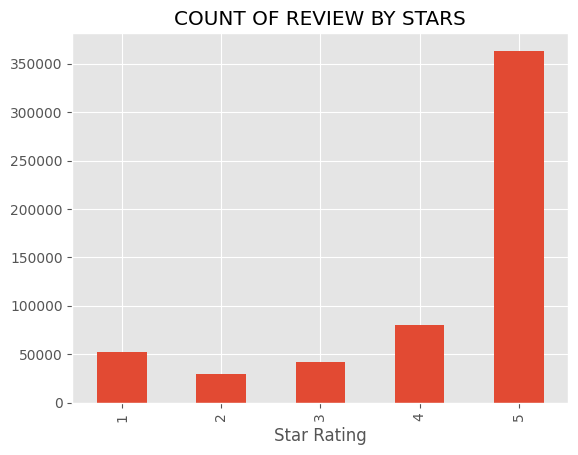

In [5]:
ax1=df['Score'].value_counts().sort_index().plot(kind='bar',title="COUNT OF REVIEW BY STARS")
ax1.set_xlabel('Star Rating')

In [6]:
#PERFORMING UNDERSAMPLING
from imblearn.under_sampling import RandomUnderSampler
rs=RandomUnderSampler(sampling_strategy={1:10000,2:10000,3:10000,4:10000,5:10000})
x_res,y_res=rs.fit_resample(df,df['Score'])

In [7]:
new_df=x_res
new_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
87506,87507,B001D0GV6I,A3U7Q41SJ4PWI,E. Maddox,0,0,1,1241654400,Way too strong for me,"I love Timothy's coffee pods, so when I bought..."
416765,416766,B0051H9FLW,A3TDYGSGB7RHIO,regolf,0,0,1,1350518400,Kingdon Pet Jerky Treats,"I must admit that my dogs LOVED these treats, ..."
134786,134787,B000EITYUU,AGTO21BHY08LF,"scottls1 ""scottls1""",2,24,1,1299456000,Celtic Sea Salt has impuriities!,Has a nice mellower taste than store bought he...
248000,248001,B004T3QMD8,AJQFYCKMA7TE3,judolphin,0,0,1,1323648000,Sanka/Nescafe & Pumpkin Spice Coffeemate is a ...,I love my frou-frou gourmet pseudo-coffee drin...
38099,38100,B000E18CS2,A2X1XUT26NRICX,Amie,5,13,1,1245283200,Not as advertised,"Rice noodles taste pretty much alike, but this..."
...,...,...,...,...,...,...,...,...,...,...
462323,462324,B003S9C79C,A22S2SUMTF3ZBX,"Terri M. Pendleton ""gidgetgoes""",0,0,5,1342569600,Absolute Life Saver!,My 14 year old kitty's mouth does not work so ...
411577,411578,B001H1BI1Q,A1PKRWQ6VBYZM3,Pat,2,2,5,1307232000,dog food,I was told about this product by our vet. I ha...
230360,230361,B00004RYGX,A2Q5Y2EMS6KDWI,"Randy E. Halford ""Comedy Fan""",1,1,5,1256601600,The ghost with the most,"After 20 years, this oddball dark comedy hasn'..."
242338,242339,B001NIZUA8,AS6349P9CX7TU,Pattie.Dery,0,0,5,1346284800,Great Product,I am always concerned with the ingredients of ...


In [8]:
#PERFORMING UNDERSAMPLING
from imblearn.under_sampling import RandomUnderSampler
rs=RandomUnderSampler(sampling_strategy={1:10000,2:10000,3:10000,4:10000,5:10000})
x_res,y_res=rs.fit_resample(df,df['Score'])

In [9]:
#AFTER UNDERSAMPLING
new_df['Score'].value_counts()

Score
1    10000
2    10000
3    10000
4    10000
5    10000
Name: count, dtype: int64

Text(0.5, 0, 'Star Rating')

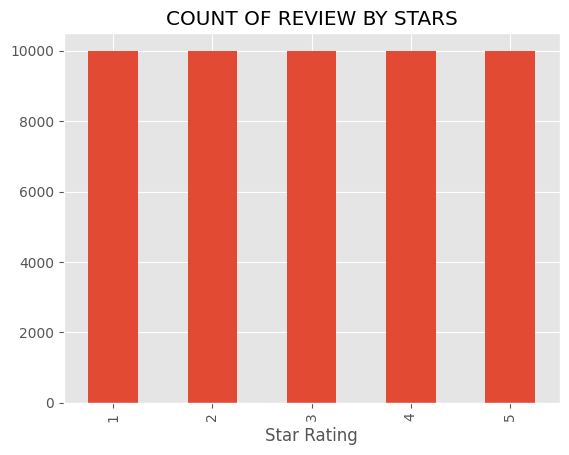

In [10]:
ax2=new_df['Score'].value_counts().sort_index().plot(kind='bar',title="COUNT OF REVIEW BY STARS")
ax2.set_xlabel('Star Rating')

# Classifying Reviews using VADER Model

In [11]:
sia=SentimentIntensityAnalyzer()

In [12]:
sia.polarity_scores(" It's as good as expected ")

{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.4404}

In [13]:
sia.polarity_scores("It's ridiculous")

{'neg': 0.714, 'neu': 0.286, 'pos': 0.0, 'compound': -0.3612}

In [14]:
sia.polarity_scores("Most of the time it is good,but rarely it fails.")

{'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'compound': 0.3252}

In [15]:
res={}
for i ,row in tqdm(new_df.iterrows(),total=len(new_df)):
    text=row['Text']
    myid=row['Id']
    res[myid]=sia.polarity_scores(text)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [16]:
vaders=pd.DataFrame(res).T
vaders

,neg,neu,pos,compound
87507,0.144,0.681,0.175,0.3818
416766,0.178,0.630,0.192,-0.1239
134787,0.017,0.896,0.087,0.7804
248001,0.050,0.807,0.143,0.9432
38100,0.104,0.840,0.056,-0.6691
...,...,...,...,...
462324,0.068,0.667,0.265,0.9926
411578,0.000,0.872,0.128,0.4215
230361,0.078,0.781,0.141,0.8983
242339,0.000,0.653,0.347,0.9710


In [17]:
vaders=vaders.rename(columns={'neg':"vaders_negative",'neu':"vaders_neutral",'pos':"vaders_positive",'compound':"vaders_compound"})

In [18]:
vaders

,vaders_negative,vaders_neutral,vaders_positive,vaders_compound
87507,0.144,0.681,0.175,0.3818
416766,0.178,0.630,0.192,-0.1239
134787,0.017,0.896,0.087,0.7804
248001,0.050,0.807,0.143,0.9432
38100,0.104,0.840,0.056,-0.6691
...,...,...,...,...
462324,0.068,0.667,0.265,0.9926
411578,0.000,0.872,0.128,0.4215
230361,0.078,0.781,0.141,0.8983
242339,0.000,0.653,0.347,0.9710


In [19]:
vaders=vaders.reset_index()
vaders

,index,vaders_negative,vaders_neutral,vaders_positive,vaders_compound
0,87507,0.144,0.681,0.175,0.3818
1,416766,0.178,0.630,0.192,-0.1239
2,134787,0.017,0.896,0.087,0.7804
3,248001,0.050,0.807,0.143,0.9432
4,38100,0.104,0.840,0.056,-0.6691
...,...,...,...,...,...
49995,462324,0.068,0.667,0.265,0.9926
49996,411578,0.000,0.872,0.128,0.4215
49997,230361,0.078,0.781,0.141,0.8983
49998,242339,0.000,0.653,0.347,0.9710


In [20]:
vaders=vaders.rename(columns={'index':'Id'})

In [21]:
vaders=vaders.merge(new_df,how='left')
vaders

,Id,vaders_negative,vaders_neutral,vaders_positive,vaders_compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,87507,0.144,0.681,0.175,0.3818,B001D0GV6I,A3U7Q41SJ4PWI,E. Maddox,0,0,1,1241654400,Way too strong for me,"I love Timothy's coffee pods, so when I bought..."
1,416766,0.178,0.630,0.192,-0.1239,B0051H9FLW,A3TDYGSGB7RHIO,regolf,0,0,1,1350518400,Kingdon Pet Jerky Treats,"I must admit that my dogs LOVED these treats, ..."
2,134787,0.017,0.896,0.087,0.7804,B000EITYUU,AGTO21BHY08LF,"scottls1 ""scottls1""",2,24,1,1299456000,Celtic Sea Salt has impuriities!,Has a nice mellower taste than store bought he...
3,248001,0.050,0.807,0.143,0.9432,B004T3QMD8,AJQFYCKMA7TE3,judolphin,0,0,1,1323648000,Sanka/Nescafe & Pumpkin Spice Coffeemate is a ...,I love my frou-frou gourmet pseudo-coffee drin...
4,38100,0.104,0.840,0.056,-0.6691,B000E18CS2,A2X1XUT26NRICX,Amie,5,13,1,1245283200,Not as advertised,"Rice noodles taste pretty much alike, but this..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,462324,0.068,0.667,0.265,0.9926,B003S9C79C,A22S2SUMTF3ZBX,"Terri M. Pendleton ""gidgetgoes""",0,0,5,1342569600,Absolute Life Saver!,My 14 year old kitty's mouth does not work so ...
49996,411578,0.000,0.872,0.128,0.4215,B001H1BI1Q,A1PKRWQ6VBYZM3,Pat,2,2,5,1307232000,dog food,I was told about this product by our vet. I ha...
49997,230361,0.078,0.781,0.141,0.8983,B00004RYGX,A2Q5Y2EMS6KDWI,"Randy E. Halford ""Comedy Fan""",1,1,5,1256601600,The ghost with the most,"After 20 years, this oddball dark comedy hasn'..."
49998,242339,0.000,0.653,0.347,0.9710,B001NIZUA8,AS6349P9CX7TU,Pattie.Dery,0,0,5,1346284800,Great Product,I am always concerned with the ingredients of ...


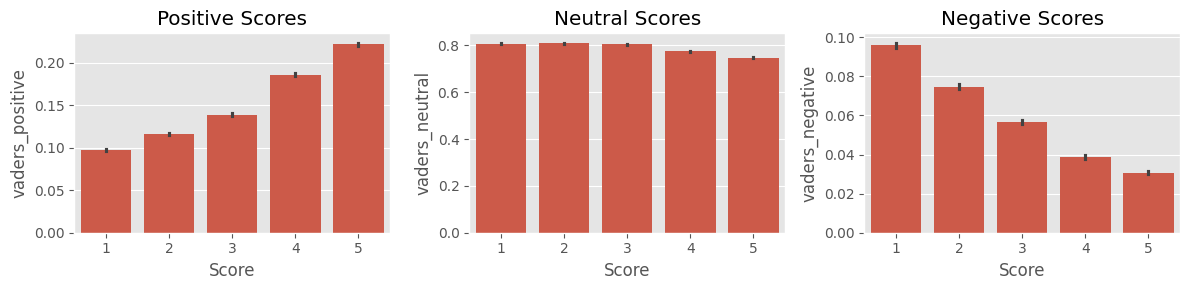

In [22]:
#Visualizing The Change In Scores With Respect To Star Ratings
fig,ax3=plt.subplots(1,3,figsize=(12,3))
sns.barplot(data=vaders,x='Score',y='vaders_positive',ax=ax3[0])
sns.barplot(data=vaders,x='Score',y='vaders_neutral',ax=ax3[1])
sns.barplot(data=vaders,x='Score',y='vaders_negative',ax=ax3[2])
ax3[0].set_title("Positive Scores")
ax3[1].set_title("Neutral Scores")
ax3[2].set_title("Negative Scores")
plt.tight_layout()

In [23]:
#Setting Threshold values
vpred=[]
for i,row in tqdm(vaders.iterrows(),total=len(vaders)):
    comp_score=row['vaders_compound']
    if(comp_score>0.4):
        vpred.append("Positve")
    elif(comp_score<0):
        vpred.append("Negative")
    else:
        vpred.append("Neutral")

  0%|          | 0/50000 [00:00<?, ?it/s]

In [24]:
vpred=pd.DataFrame(vpred)

In [25]:
vaders_fin=pd.concat([vaders,vpred],axis=1)

In [26]:
vaders_fin=vaders_fin.rename(columns={0:'Vaders Prediction'})
vaders_fin

,Id,vaders_negative,vaders_neutral,vaders_positive,vaders_compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Vaders Prediction
0,87507,0.144,0.681,0.175,0.3818,B001D0GV6I,A3U7Q41SJ4PWI,E. Maddox,0,0,1,1241654400,Way too strong for me,"I love Timothy's coffee pods, so when I bought...",Neutral
1,416766,0.178,0.630,0.192,-0.1239,B0051H9FLW,A3TDYGSGB7RHIO,regolf,0,0,1,1350518400,Kingdon Pet Jerky Treats,"I must admit that my dogs LOVED these treats, ...",Negative
2,134787,0.017,0.896,0.087,0.7804,B000EITYUU,AGTO21BHY08LF,"scottls1 ""scottls1""",2,24,1,1299456000,Celtic Sea Salt has impuriities!,Has a nice mellower taste than store bought he...,Positve
3,248001,0.050,0.807,0.143,0.9432,B004T3QMD8,AJQFYCKMA7TE3,judolphin,0,0,1,1323648000,Sanka/Nescafe & Pumpkin Spice Coffeemate is a ...,I love my frou-frou gourmet pseudo-coffee drin...,Positve
4,38100,0.104,0.840,0.056,-0.6691,B000E18CS2,A2X1XUT26NRICX,Amie,5,13,1,1245283200,Not as advertised,"Rice noodles taste pretty much alike, but this...",Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,462324,0.068,0.667,0.265,0.9926,B003S9C79C,A22S2SUMTF3ZBX,"Terri M. Pendleton ""gidgetgoes""",0,0,5,1342569600,Absolute Life Saver!,My 14 year old kitty's mouth does not work so ...,Positve
49996,411578,0.000,0.872,0.128,0.4215,B001H1BI1Q,A1PKRWQ6VBYZM3,Pat,2,2,5,1307232000,dog food,I was told about this product by our vet. I ha...,Positve
49997,230361,0.078,0.781,0.141,0.8983,B00004RYGX,A2Q5Y2EMS6KDWI,"Randy E. Halford ""Comedy Fan""",1,1,5,1256601600,The ghost with the most,"After 20 years, this oddball dark comedy hasn'...",Positve
49998,242339,0.000,0.653,0.347,0.9710,B001NIZUA8,AS6349P9CX7TU,Pattie.Dery,0,0,5,1346284800,Great Product,I am always concerned with the ingredients of ...,Positve


# Classifying Reviews using ROBERTA Pretrained Model

In [27]:
MODEL=f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(MODEL)

In [28]:
model=AutoModelForSequenceClassification.from_pretrained(MODEL)

In [29]:
def roberta_polarity_scores(text):
  encoded_txt=tokenizer(text,return_tensors='pt')
  output=model(**encoded_txt)
  scores=output[0][0].detach().numpy()
  scores=softmax(scores)
  scores_dict={'roberta_negative':scores[0],'roberta_neutral':scores[1],'roberta_positive':scores[2]}
  return scores_dict

In [30]:
result={}
for i ,row in tqdm(new_df.iterrows(),total=len(new_df)):
  try:
    text=row['Text']
    myid=row['Id']
    result[myid]=roberta_polarity_scores(text)
  except Exception as e:
        print(f"Error processing text: {myid}, error: {e}")

  0%|          | 0/50000 [00:00<?, ?it/s]

Error processing text: 224261, error: The expanded size of the tensor (1073) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1073].  Tensor sizes: [1, 514]
Error processing text: 369825, error: The expanded size of the tensor (605) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 605].  Tensor sizes: [1, 514]
Error processing text: 468231, error: The expanded size of the tensor (582) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 582].  Tensor sizes: [1, 514]
Error processing text: 149020, error: The expanded size of the tensor (543) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 543].  Tensor sizes: [1, 514]
Error processing text: 144950, error: The expanded size of the tensor (1073) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1073].  Tensor sizes: [1, 514]
Error processing text: 149983, error: The expa

In [31]:
result

{87507: {'roberta_negative': 0.18457924,
  'roberta_neutral': 0.3453169,
  'roberta_positive': 0.47010383},
 416766: {'roberta_negative': 0.25290042,
  'roberta_neutral': 0.2916631,
  'roberta_positive': 0.45543647},
 134787: {'roberta_negative': 0.2291124,
  'roberta_neutral': 0.40064034,
  'roberta_positive': 0.3702473},
 248001: {'roberta_negative': 0.6327481,
  'roberta_neutral': 0.26178032,
  'roberta_positive': 0.1054715},
 38100: {'roberta_negative': 0.8926601,
  'roberta_neutral': 0.0974255,
  'roberta_positive': 0.009914378},
 370979: {'roberta_negative': 0.1503759,
  'roberta_neutral': 0.23400378,
  'roberta_positive': 0.6156204},
 87417: {'roberta_negative': 0.18841241,
  'roberta_neutral': 0.45624906,
  'roberta_positive': 0.35533857},
 306326: {'roberta_negative': 0.97833896,
  'roberta_neutral': 0.018964998,
  'roberta_positive': 0.0026961006},
 182512: {'roberta_negative': 0.95054,
  'roberta_neutral': 0.046007365,
  'roberta_positive': 0.0034526146},
 363291: {'roberta_

In [32]:
roberta=pd.DataFrame(result).T
roberta=roberta.reset_index().rename(columns={'index':'Id'})

In [33]:
roberta

,Id,roberta_negative,roberta_neutral,roberta_positive
0,87507,0.184579,0.345317,0.470104
1,416766,0.252900,0.291663,0.455436
2,134787,0.229112,0.400640,0.370247
3,248001,0.632748,0.261780,0.105471
4,38100,0.892660,0.097425,0.009914
...,...,...,...,...
49334,462324,0.046015,0.080748,0.873237
49335,411578,0.075285,0.456471,0.468244
49336,230361,0.337652,0.457239,0.205109
49337,242339,0.006587,0.061397,0.932016


In [34]:
roberta=roberta.merge(vaders_fin,how='left')

In [35]:
roberta_polarity_scores("It's good as expected")

{'roberta_negative': 0.004768506,
 'roberta_neutral': 0.03425236,
 'roberta_positive': 0.96097916}

In [36]:
roberta_polarity_scores("It's ridiculous")

{'roberta_negative': 0.84095603,
 'roberta_neutral': 0.13255285,
 'roberta_positive': 0.026491087}

In [37]:
roberta_polarity_scores("Most of the time it is good,but rarely it fails.")

{'roberta_negative': 0.08156551,
 'roberta_neutral': 0.31656712,
 'roberta_positive': 0.6018673}

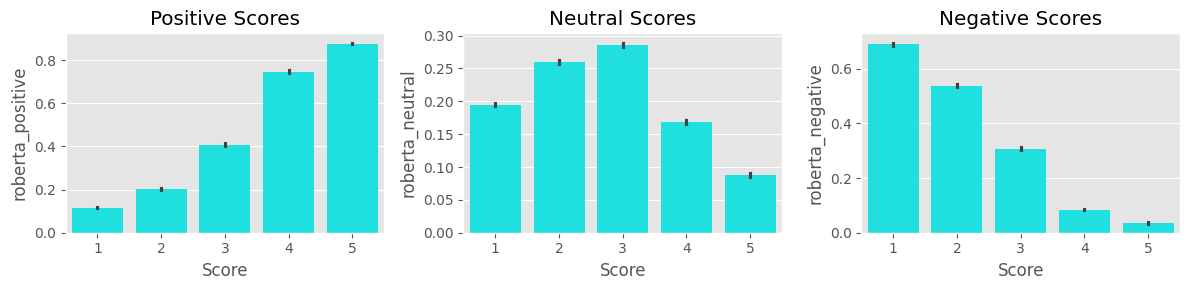

In [38]:
#Visualizing The Change In Scores With Respect To Star Ratings
fig,ax4=plt.subplots(1,3,figsize=(12,3))
sns.barplot(data=roberta,x='Score',y='roberta_positive',ax=ax4[0],color='cyan')
sns.barplot(data=roberta,x='Score',y='roberta_neutral',ax=ax4[1],color='cyan')
sns.barplot(data=roberta,x='Score',y='roberta_negative',ax=ax4[2],color='cyan')
ax4[0].set_title("Positive Scores")
ax4[1].set_title("Neutral Scores")
ax4[2].set_title("Negative Scores")
plt.tight_layout()

In [39]:
#Setting Threshold Values
rpred=[]
for i,row in tqdm(roberta.iterrows(),total=len(roberta)):
    compute_scores=[row['roberta_negative'],row['roberta_neutral'],row['roberta_positive']]
    if(max(compute_scores)==compute_scores[0]):
        rpred.append("Negative")
    elif(max(compute_scores)==compute_scores[1]):
        rpred.append("Neutral")
    else:
        rpred.append("Positive")

  0%|          | 0/49339 [00:00<?, ?it/s]

In [40]:
rpred=pd.DataFrame(rpred)

In [41]:
roberta_fin=pd.concat([roberta,rpred],axis=1)
roberta_fin=roberta_fin.rename(columns={0:"Roberta Prediction"})
roberta_fin

,Id,roberta_negative,roberta_neutral,roberta_positive,vaders_negative,vaders_neutral,vaders_positive,vaders_compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Vaders Prediction,Roberta Prediction
0,87507,0.184579,0.345317,0.470104,0.144,0.681,0.175,0.3818,B001D0GV6I,A3U7Q41SJ4PWI,E. Maddox,0,0,1,1241654400,Way too strong for me,"I love Timothy's coffee pods, so when I bought...",Neutral,Positive
1,416766,0.252900,0.291663,0.455436,0.178,0.630,0.192,-0.1239,B0051H9FLW,A3TDYGSGB7RHIO,regolf,0,0,1,1350518400,Kingdon Pet Jerky Treats,"I must admit that my dogs LOVED these treats, ...",Negative,Positive
2,134787,0.229112,0.400640,0.370247,0.017,0.896,0.087,0.7804,B000EITYUU,AGTO21BHY08LF,"scottls1 ""scottls1""",2,24,1,1299456000,Celtic Sea Salt has impuriities!,Has a nice mellower taste than store bought he...,Positve,Neutral
3,248001,0.632748,0.261780,0.105471,0.050,0.807,0.143,0.9432,B004T3QMD8,AJQFYCKMA7TE3,judolphin,0,0,1,1323648000,Sanka/Nescafe & Pumpkin Spice Coffeemate is a ...,I love my frou-frou gourmet pseudo-coffee drin...,Positve,Negative
4,38100,0.892660,0.097425,0.009914,0.104,0.840,0.056,-0.6691,B000E18CS2,A2X1XUT26NRICX,Amie,5,13,1,1245283200,Not as advertised,"Rice noodles taste pretty much alike, but this...",Negative,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49334,462324,0.046015,0.080748,0.873237,0.068,0.667,0.265,0.9926,B003S9C79C,A22S2SUMTF3ZBX,"Terri M. Pendleton ""gidgetgoes""",0,0,5,1342569600,Absolute Life Saver!,My 14 year old kitty's mouth does not work so ...,Positve,Positive
49335,411578,0.075285,0.456471,0.468244,0.000,0.872,0.128,0.4215,B001H1BI1Q,A1PKRWQ6VBYZM3,Pat,2,2,5,1307232000,dog food,I was told about this product by our vet. I ha...,Positve,Positive
49336,230361,0.337652,0.457239,0.205109,0.078,0.781,0.141,0.8983,B00004RYGX,A2Q5Y2EMS6KDWI,"Randy E. Halford ""Comedy Fan""",1,1,5,1256601600,The ghost with the most,"After 20 years, this oddball dark comedy hasn'...",Positve,Neutral
49337,242339,0.006587,0.061397,0.932016,0.000,0.653,0.347,0.9710,B001NIZUA8,AS6349P9CX7TU,Pattie.Dery,0,0,5,1346284800,Great Product,I am always concerned with the ingredients of ...,Positve,Positive


# Analayzing the Classifications of VADER and ROBERTA Pretrained Models

In [42]:
pd.set_option('display.max_colwidth', None)

In [43]:
comp_df=roberta_fin[['Id','Summary','Score','Text','Vaders Prediction','Roberta Prediction']]
comp_df

,Id,Summary,Score,Text,Vaders Prediction,Roberta Prediction
0,87507,Way too strong for me,1,"I love Timothy's coffee pods, so when I bought a Keurig, naturally I bought Timothy's. I bought two flavored coffees but they are way too bold and strong for a morning coffee drinker. I am now trying Gloria Jean, Emeril and Caribou, looking for a pleasant morning cup. I may consider opening up the K-cups to see if I can dump the contents into a toddy maker, I hate to toss these, but find them unpleasantly harsh.",Neutral,Positive
1,416766,Kingdon Pet Jerky Treats,1,"I must admit that my dogs LOVED these treats, but in the light of so many recalls due to their making dogs sick, I immediately stopped giving them to my dogs.",Negative,Positive
2,134787,Celtic Sea Salt has impuriities!,1,"Has a nice mellower taste than store bought heat-processed table salt.<br /><br />No Iodine, so I supplement with 4 drops of good tasting Liquid Dulse <a href=""http://www.amazon.com/gp/product/B00014HV48"">Bernard Jensen Products - Liquid Dulse, 4 oz liquid</a> (also Very good to FILL thyroid with GOOD iodine!- Keeps from taking in any Radioactive iodine from Japan reactor spill!- Radioactive iodine does Permanent damage to thyroid, and can't be reversed! Radioactivity is sure to work into our food supply...!)<br /><br />Per my dentist (for everyone)- I started gargling with 1/4tsp salt in 8oz of water after brushing.<br />It is VERY unnerving to see the undissolved black/brown specs floating around!<br /><br />The other unprocessed sea salt brands come from ""Less"" pristine waters, but I'll give them a try next time.",Positve,Neutral
3,248001,Sanka/Nescafe & Pumpkin Spice Coffeemate is a much better quick cuppa than this glorified cup of sugar water,1,"I love my frou-frou gourmet pseudo-coffee drinks as much as the next guy (I love pumpkin spice coffee in general). I remember my parents buying ""International Coffees"" so I thought I'd give this a try.<br /><br />I want to be clear that I was not expecting this to be on par with an espresso-based drink that costs $4. I decided instead to compare this to a cup of instant coffee (Nescafe) with Coffeemate's Pumpkin Spice Creamer -- which should be a fair comparison.<br /><br />Unfortunately, this comes nowhere close to fulfilling even that modest expectation. These bad boys are completely flavorless unless you double or triple the amount they suggest. And when you do that, you feel like you're drinking a cup of hot sugar water -- there is no coffee to be found in here. Pretty disgusting for me and my wife's tastes.<br /><br />In my opinion, you'd be better off buying regular instant coffee and a bottle of pumpkin spice Coffeemate. It's 100 times better than this.",Positve,Negative
4,38100,Not as advertised,1,"Rice noodles taste pretty much alike, but this is the second time I have ordered rice noodles from Amazon in the last two weeks only to discover they are not as advertised on the website. In this case the website states that these noodles are made in the US. They are not. The box states they are a product of Thailand. I do not appreciate this misrepresentation at all.",Negative,Negative
...,...,...,...,...,...,...
49334,462324,Absolute Life Saver!,5,"My 14 year old kitty's mouth does not work so well anymore, and she has trouble eating most of the grain free wet foods, which tend to be too chunky or solid. This awesome wet food is full of jelly and broth as well as meat, and it's PERFECT for an old kitty's mouth. She has not eaten a full helping of cat food in YEARS, but the very first can of this stuff I set out for her was GONE almost instantly. She is usually constantly screaming for treats, but after having a full 3 ounce can of this, she is happy and scream free. I have never seen her take to a wet food so instantly and so completely. Yes, it smells like tuna...because it's made from tuna? It's pungent but she frickin' LOVES it. How nice to see my poor old girl eat every last bit of something. I

In [44]:
comp_df['Vaders Prediction'].value_counts()

Vaders Prediction
Positve     32698
Negative    10680
Neutral      5961
Name: count, dtype: int64

In [45]:
comp_df['Roberta Prediction'].value_counts()

Roberta Prediction
Positive    24843
Negative    18302
Neutral      6194
Name: count, dtype: int64

In [46]:
inacc=[]
for i ,rows in tqdm(comp_df.iterrows(),total=len(comp_df)):
    vad=rows['Vaders Prediction']
    rob=rows['Roberta Prediction']
    star=rows['Score']
    if(vad!=rob):
        inacc.append([rows['Id'],star,vad,rob])

  0%|          | 0/49339 [00:00<?, ?it/s]

In [47]:
inacc[16]

[504709, 1, 'Positve', 'Negative']

In [48]:
comp_df[comp_df['Id']==381722]['Text']  #THIS IS CLEARLY A NEGATIVE COMMENT AS STATED BY ROBERTA MODEL

Series([], Name: Text, dtype: object)

In [49]:
inacc[26]

[239230, 1, 'Positve', 'Neutral']

In [50]:
comp_df[comp_df['Id']==146672]['Text']  #THIS IS CLEARLY A NEGATIVE STATEMENT [WITH SOME SARCASM!!] AS PREDICTED BY ROBERTA MODEL

Series([], Name: Text, dtype: object)

In [51]:
inacc[39]

[392442, 1, 'Positve', 'Negative']

In [52]:
comp_df[comp_df['Id']==534414]['Text']  #THIS IS CLEARLY A NEGATIVE STATEMENT AS PREDICTED BY ROBERTA MODEL

Series([], Name: Text, dtype: object)

In [53]:
# SO IT IS EVIDENT THAT ROBERTA PRETRAINED MODEL PERFORMS BETTER THAN VADER MODEL IN CASES OF COMPLEX RELATIONSHIPS BETWEEN WORDS

# Sentiment Analysis using ROBERTA PRETRAINED Model

In [54]:
def trying(example):
    cal=roberta_polarity_scores(example)
    s1,s2,s3=cal.get("roberta_negative"),cal.get("roberta_neutral"),cal.get("roberta_positive")
    if(max(s1,s2,s3)==s1):
       print("THE STATEMENT IS NEGATIVE")
    elif(max(s1,s2,s3)==s2):
       print("THE STATEMENT IS NEUTRAL")
    else:
        print("THE STATEMENT IS POSITIVE")

In [55]:
#TRY ANY STATEMENT HERE
trying("HE GOT SUCH LOW MARKS HOW CAN I BE HAPPY ABOUT IT")

THE STATEMENT IS NEGATIVE
